## Import libraries

In [27]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
# Set up directories
data_dir = 'data'
output_dir = 'output'
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

## Ingest the data
Read in the test and training data from their downloaded location

In [116]:
res = pd.read_csv(os.path.join(data_dir, 'resources.csv'))
train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
test = pd.read_csv(os.path.join(data_dir, 'train.csv'))

## Check out the data
High level investigation. What are the attributes? Summary statistics of each?

In [30]:
list(res.columns)

['id', 'description', 'quantity', 'price']

In [31]:
list(train.columns)

['id',
 'teacher_id',
 'teacher_prefix',
 'school_state',
 'project_submitted_datetime',
 'project_grade_category',
 'project_subject_categories',
 'project_subject_subcategories',
 'project_title',
 'project_essay_1',
 'project_essay_2',
 'project_essay_3',
 'project_essay_4',
 'project_resource_summary',
 'teacher_number_of_previously_posted_projects',
 'project_is_approved']

In [6]:
res.describe(include='all')

,id,description,quantity,price
count,1541272,1540980,1.541272e+06,1.541272e+06
unique,260115,332928,NaN,NaN
top,p066966,Apple - iPad� mini 2 with Wi-Fi - 16GB - Space...,NaN,NaN
freq,100,3037,NaN,NaN
mean,NaN,NaN,2.860509e+00,5.028398e+01
std,NaN,NaN,7.570345e+00,1.447326e+02
min,NaN,NaN,1.000000e+00,0.000000e+00
25%,NaN,NaN,1.000000e+00,7.900000e+00
50%,NaN,NaN,1.000000e+00,1.499000e+01
75%,NaN,NaN,2.000000e+00,3.980000e+01


In [7]:
train.describe(include='all')

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
count,182080,182080,182076,182080,182080,182080,182080,182080,182080,182080,182080,6374,6374,182080,182080.000000,182080.000000
unique,182080,104414,5,51,180439,4,51,407,164282,147689,180984,6359,6336,179730,NaN,NaN
top,p207545,fa2f220b537e8653fb48878ebb38044d,Mrs.,CA,2016-09-01 00:00:03,Grades PreK-2,Literacy & Language,Literacy,Flexible Seating,As a teacher in a low-income/high poverty scho...,Students will be using Chromebooks to increase...,We will use these class sets of Scholastic mag...,"Having taught engineering in college, I have c...",My students need electronic tablets to do all ...,NaN,NaN
freq,1,74,95405,25695,30,73890,39257,15775,377,46,24,2,3,84,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.237055,0.847682
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.016086,0.359330
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,1.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.000000,1.000000


Essays are an interesting chunk of this dataset and potentially have a wealth of information in them. Every application has questions 1 and 2, but the counts of questions 3 and 4 are significantly lower. Typically if there are large amounts of missing data in an attribute, it would be thrown out. However, I believe that removing `project_essay_3` and `project_essay_4` from consideration would throw away useful data. According to the data description: 
>Note: Prior to May 17, 2016, the prompts for the essays were as follows:
- `project_essay_1`: "Introduce us to your classroom"
- `project_essay_2`: "Tell us more about your students"
- `project_essay_3`: "Describe how your students will use the materials you're requesting"
- `project_essay_4`: "Close by sharing why your project will make a difference"

>Starting on May 17, 2016, the number of essays was reduced from 4 to 2, and the prompts for the first 2 essays were changed to the following:
- `project_essay_1`: "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."
- `project_essay_2`: "About your project: How will these materials make a difference in your students' learning and improve their school lives?"

To me, the newer question 1 appears to be a combination of the old questions 1 and 2, while the newer question 2 appears to be a combination of the old questions 3 and 4. The old questions 1 and 2 ask about the classroom and students, while the new question 2 asks about the students and the school. The old questions 3 and 4 ask about how materials will be used and how they will make a difference, while the new question 2 addresses the same topics.

As such I will combine the old question 1 and 2 into question 1, and the old question 3 and 4 into quesiton 2.

## Combine relevant data 

In [105]:
def merge_question_text(df):
    '''
    Looks at 4 values, if #3 and #4 are filled, 
    then combine #1 and #2 into #1, 
    and combine #3 and #4 into #2
    '''
    
    for row in df.itertuples():
        q1 = getattr(row, 'project_essay_1')
        q2 = getattr(row, 'project_essay_2')
        q3 = getattr(row, 'project_essay_3')
        q4 = getattr(row, 'project_essay_4')
        if (q3 == q3) and (q4 == q4):
            q1 = ' '.join((q1, q2))
            q2 = ' '.join((q3, q4))
        break
            

In [121]:
df['project_essay_1'] + df['project_essay_4']
# FIXME

0                                                       NaN
1                                                       NaN
2                                                       NaN
3                                                       NaN
4                                                       NaN
5                                                       NaN
6                                                       NaN
7                                                       NaN
8                                                       NaN
9                                                       NaN
10                                                      NaN
11                                                      NaN
12                                                      NaN
13                                                      NaN
14                                                      NaN
15                                                      NaN
16                                      

## Calculate price totals for each request ID

In [123]:
# Get sum of each application request
res['total'] = res['quantity'] * res['price']
res_unique = res.groupby(by='id').sum()

## Merge unique resource data with test and training data

In [124]:
# Map to the training set
df = pd.merge(train, res_unique, how='left', left_on='id', right_on='id')
df_test = pd.merge(test, res_unique, how='left', left_on='id', right_on='id')

In [125]:
df.head()

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,quantity,price,total
0,p036502,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,Literacy & Language,Literacy,Super Sight Word Centers,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,NaN,NaN,My students need 6 Ipod Nano's to create and d...,26,1,6,299.98,899.94
1,p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,NaN,My students need matching shirts to wear for d...,1,0,20,20.00,400.00
2,p233823,a9b876a9252e08a55e3d894150f75ba3,Ms.,UT,2017-01-01 22:57:44,Grades 3-5,"Math & Science, Literacy & Language","Applied Sciences, Literature & Writing",Lets 3Doodle to Learn,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...,NaN,NaN,My students need the 3doodler. We are an SEM s...,5,1,1,469.99,469.99
3,p185307,525fdbb6ec7f538a48beebaa0a51b24f,Mr.,NC,2016-08-12 15:42:11,Grades 3-5,Health & Sports,Health & Wellness,"\""Kid Inspired\"" Equipment to Increase Activit...",My students are the greatest students but are ...,"The student's project which is totally \""kid-i...",NaN,NaN,My students need balls and other activity equi...,16,0,5,684.47,684.47
4,p013780,a63b5547a7239eae4c1872670848e61a,Mr.,CA,2016-08-06 09:09:11,Grades 6-8,Health & Sports,Health & Wellness,We need clean water for our culinary arts class!,My students are athletes and students who are ...,For some reason in our kitchen the water comes...,NaN,NaN,My students need a water filtration system for...,42,1,2,355.50,711.00


In [150]:
df_test.head()

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,quantity,price,total
0,p036502,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,Literacy & Language,Literacy,Super Sight Word Centers,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,NaN,NaN,My students need 6 Ipod Nano's to create and d...,26,1,6,299.98,899.94
1,p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,NaN,My students need matching shirts to wear for d...,1,0,20,20.00,400.00
2,p233823,a9b876a9252e08a55e3d894150f75ba3,Ms.,UT,2017-01-01 22:57:44,Grades 3-5,"Math & Science, Literacy & Language","Applied Sciences, Literature & Writing",Lets 3Doodle to Learn,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...,NaN,NaN,My students need the 3doodler. We are an SEM s...,5,1,1,469.99,469.99
3,p185307,525fdbb6ec7f538a48beebaa0a51b24f,Mr.,NC,2016-08-12 15:42:11,Grades 3-5,Health & Sports,Health & Wellness,"\""Kid Inspired\"" Equipment to Increase Activit...",My students are the greatest students but are ...,"The student's project which is totally \""kid-i...",NaN,NaN,My students need balls and other activity equi...,16,0,5,684.47,684.47
4,p013780,a63b5547a7239eae4c1872670848e61a,Mr.,CA,2016-08-06 09:09:11,Grades 6-8,Health & Sports,Health & Wellness,We need clean water for our culinary arts class!,My students are athletes and students who are ...,For some reason in our kitchen the water comes...,NaN,NaN,My students need a water filtration system for...,42,1,2,355.50,711.00


## Breakdown the data to spot trends
The first look will be at teacher prefixes. Do proposals with Mrs. have a better/worse acceptance rate than Mr.?

In [142]:
dp = df.pivot_table(columns='teacher_prefix', index='project_is_approved', values='id', aggfunc='count')
dp

teacher_prefix,Dr.,Mr.,Mrs.,Ms.,Teacher
project_is_approved,,,,,
0,5,2791,13921,10212,805
1,21,14876,81484,54854,3107


In [148]:
pct = 1 - dp.iloc[0,:]/dp.iloc[1,:]
pct

teacher_prefix
Dr.        0.761905
Mr.        0.812382
Mrs.       0.829157
Ms.        0.813833
Teacher    0.740908
dtype: float64

This title breakdown shows that the acceptance rate does not vary widely between different `teacher_prefix`es, but it does vary. **A proposal with "Mrs." is 10% more likely to be accepted than a proposal with "Teacher".**

Next we will look at the influence of states.

In [171]:
dp = df.pivot_table(columns='school_state', index='project_is_approved', values='id', aggfunc='count')
pct = 1 - dp.iloc[0,:]/dp.iloc[1,:]
pct = pct.sort_values()
pct

school_state
DC    0.769441
TX    0.774014
NM    0.783533
FL    0.787144
MT    0.792453
AR    0.798222
LA    0.800972
GA    0.801084
OK    0.801565
UT    0.802553
MD    0.804243
AZ    0.811966
ID    0.812166
NJ    0.814276
MS    0.814301
HI    0.814461
RI    0.815461
MI    0.815836
WI    0.816739
CO    0.817669
IA    0.818182
IN    0.820667
AL    0.821300
VT    0.822034
AK    0.822410
TN    0.826159
NE    0.826190
PA    0.827038
KS    0.827434
NC    0.828326
NY    0.828467
IL    0.828754
VA    0.830675
OR    0.831219
CA    0.832364
NV    0.832825
MN    0.833712
MO    0.833882
KY    0.834138
ME    0.835211
MA    0.837396
SD    0.840376
SC    0.843828
ND    0.846512
NH    0.846758
WV    0.847527
WA    0.847993
CT    0.852282
OH    0.852509
WY    0.858065
DE    0.878095
dtype: float64

That's a bit hard to analyze quickly, let's see what it looks like visually.

(0.7194406548431105, 0.9280952380952381)

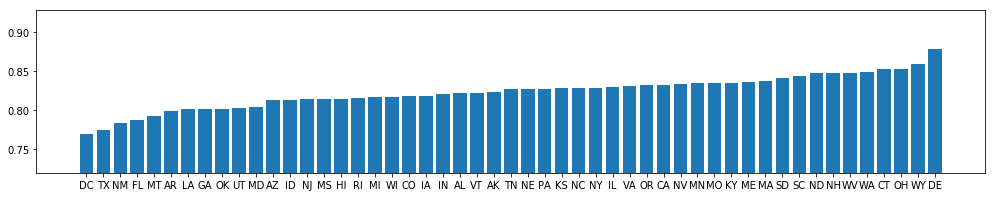

In [180]:
fig, ax = plt.subplots(figsize=(17, 3))
plt.bar(list(pct.index), pct)
ax.set_ylim([pct.min()-0.05, pct.max()+0.05])

{'whiskers': [<matplotlib.lines.Line2D at 0x12cc52978>,
 'caps': [<matplotlib.lines.Line2D at 0x129fdb278>,
 'boxes': [<matplotlib.lines.Line2D at 0x12cc52828>],
 'medians': [<matplotlib.lines.Line2D at 0x129fdbac8>],
 'fliers': [<matplotlib.lines.Line2D at 0x129fdbef0>],
 'means': []}

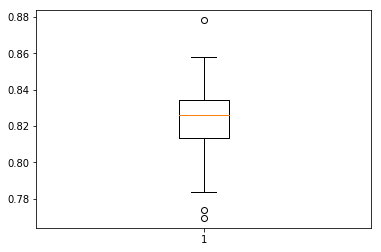

In [182]:
plt.boxplot(pct)

Yes, it does appear that the origin state may have a (small) affect. The bulk of the states have an acceptance rate of 81% to 83%, but there is some skew on the higher and lower ends.

This appears it could be an artifact from population differences, so let's see the counts.

In [189]:
num = dp.sum().sort_values()
num

school_state
VT      139
WY      177
ND      248
MT      384
RI      475
NE      493
SD      494
AK      557
NH      587
DE      589
ME      827
WV      839
HI      869
DC      902
NM      916
KS     1060
IA     1079
ID     1113
AR     1757
CO     1887
MN     2055
OR     2119
KY     2172
MS     2222
NV     2297
MD     2480
CT     2766
UT     2814
TN     2836
AL     2955
WI     2983
VA     3446
AZ     3614
NJ     3671
OK     3829
WA     3903
LA     3946
MA     4054
OH     4139
MO     4247
IN     4314
PA     5093
MI     5324
SC     6463
GA     6636
IL     7332
NC     8463
FL    10359
NY    12157
TX    12304
CA    25695
dtype: int64

(138.95, 25695.05)

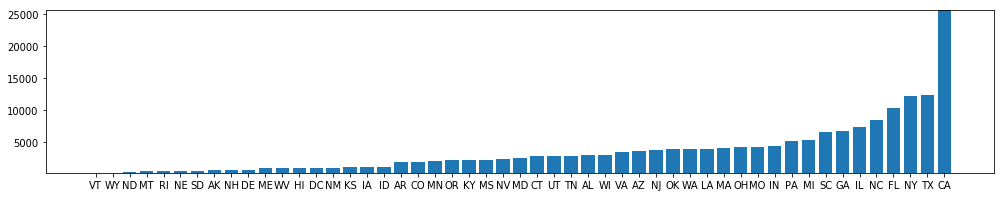

In [192]:
fig, ax = plt.subplots(figsize=(17, 3))
plt.bar(list(num.index), num)
ax.set_ylim([num.min()-0.05, num.max()+0.05])

Yes, there is a large discrepancy in the number of applications per state. Very interesting, this reduces the significance of the previous conclusion that state origin had an affect. That result may just be an artifact of imbalanced sampling. 

##FIXME choropleth
##FIXME this plot but normalized and be

In [18]:
df['project_submitted_datetime'] = pd.to_datetime(df['project_submitted_datetime'])
df.groupby(df['project_submitted_datetime'].dt.year).sum()

,teacher_number_of_previously_posted_projects,project_is_approved,quantity,price,total
project_submitted_datetime,,,,,
2016,1338682,111107,2305594,4.039384e+07,7.372773e+07
2017,707361,43239,784567,1.381707e+07,2.564224e+07
